In [1]:
from information import *
from preprocessing import *
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from snfpy.snf import snf
import snf
from sklearn.cluster import spectral_clustering
import functions as ff
from sklearn.cluster import KMeans
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

dist = 'euclidean'
    

## Reading Homogenoues MIMIC-III similarity matrices

In [2]:
import pandas as pd
import numpy as np
D = np.load('data/MIMIC-III/temp Data/diagnosis.npy')
M = np.load('data/MIMIC-III/temp Data/medication.npy')
R = np.load('data/MIMIC-III/temp Data/procedure.npy')

print(D.shape, M.shape, R.shape)

Lung_DB = [M, R]
# Lung_DB = [D, M, R]

Lung_patients = pd.read_csv('data/MIMIC-III/temp Data/patients.csv')['Patient']

(998, 998) (998, 998) (998, 998)


In [3]:
df = pd.read_csv('data/MIMIC-III/GCN emb/survival.csv')[['SUBJECT_ID','ADMITTIME','DEATHTIME']]

# Convert datetime columns to datetime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'])

# Calculate time difference in days between ADMITTIME and DEATHTIME
df['DAYS'] = (df['DEATHTIME'] - df['ADMITTIME']).dt.days
df['STATUS'] = df['DEATHTIME'].notnull().astype(int)
df['DAYS'].fillna(60, inplace=True)

new_df = df
new_df

,SUBJECT_ID,ADMITTIME,DEATHTIME,DAYS,STATUS
0,56,2104-01-02 02:01:00,2104-01-08 10:30:00,6.0,1
1,103,2144-08-12 17:37:00,2144-09-01 14:28:00,19.0,1
2,150,2161-07-09 17:54:00,NaT,60.0,0
3,222,2142-06-11 07:15:00,NaT,60.0,0
4,281,2101-10-18 04:42:00,2101-10-25 19:10:00,7.0,1
...,...,...,...,...,...
993,99339,2145-10-14 02:26:00,NaT,60.0,0
994,99384,2117-11-29 07:15:00,NaT,60.0,0
995,99469,2183-04-16 23:20:00,2183-05-13 16:20:00,26.0,1
996,99556,2165-12-25 12:44:00,2167-07-31 21:53:00,583.0,1


In [5]:
affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, _ = snf.get_n_clusters(fused_network)

Lung_labels = spectral_clustering(fused_network, n_clusters=best)

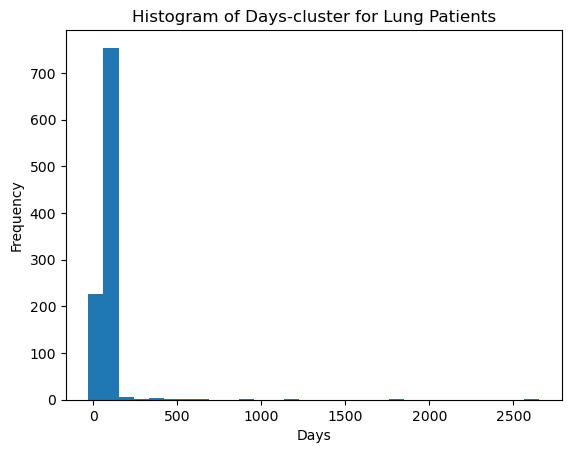

102.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                    93.0                   236.0


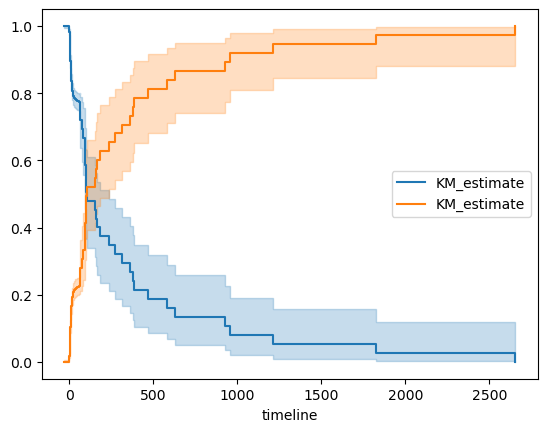

In [6]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels) }
df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

data = Lung_survival

T = data['DAYS']
E = data['STATUS']

plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Histogram of Days-cluster for Lung Patients')
plt.hist(T, bins = 30)
plt.show()

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot()

kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

# 2 Clusters for Lung

In [7]:
affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
fused_network = snf.snf(affinity_networks, K=20)
best, second = snf.get_n_clusters(fused_network)
print(best, second)
Lung_labels = spectral_clustering(fused_network, n_clusters=best)

2 4


In [8]:
new_df.to_csv('data/lung_patients.csv')

Number of patients in cluser 0 = 623
Number of patients in cluser 1 = 375
99.0
     Cluster 1_lower_0.95  Cluster 1_upper_0.95
0.5                  64.0                 270.0
P-value = (0,1) 3.2625816413387116e-08


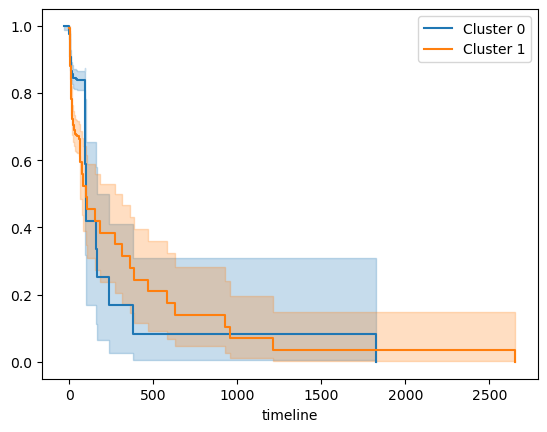

In [9]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels)}

df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)

# 4 clusters for Lung
- fusing all the PSG into one SNF (fused_network)
- find the clustering...


In [10]:
# affinity_networks = snf.make_affinity(Lung_DB, metric=dist, K=20, mu=0.5)
# fused_network = snf.snf(affinity_networks, K=20)
# best, second = snf.get_n_clusters(fused_network)

# print(best, second)

Lung_labels = spectral_clustering(fused_network, n_clusters=second)

Number of patients in cluser 0 = 472
Number of patients in cluser 1 = 315
Number of patients in cluser 2 = 66
Number of patients in cluser 3 = 145
155.0
     Cluster 3_lower_0.95  Cluster 3_upper_0.95
0.5                  93.0                1826.0
P-value = (0,1) 0.014956587291630167
P-value = (0,2) 0.0027949497962610446
P-value = (0,3) 2.375263132190034e-08
P-value = (1,2) 3.0096051624625183e-05
P-value = (1,3) 2.8207183702360504e-12
P-value = (2,3) 0.1210121507221202


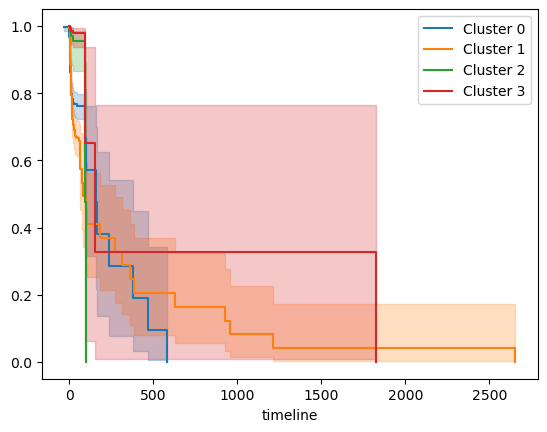

In [11]:
Lung_All     = {'SUBJECT_ID': Lung_patients    , 'cluster': list(Lung_labels)}

df_lung = pd.DataFrame(Lung_All)

Lung_survival = pd.merge(df_lung, new_df, on='SUBJECT_ID')

clusters = Lung_survival['cluster'].unique()

groups = dict(tuple(Lung_survival.groupby('cluster')))

for i in range(len(groups)):
    print(f'Number of patients in cluser {i} = {len(groups[i])}')
    
Ts = [groups[i]['DAYS'] for i in range(len(groups))]
Es = [groups[i]['STATUS'] for i in range(len(groups))]

kmf = KaplanMeierFitter()
for i in range(len(groups)):
    kmf.fit(durations = Ts[i], event_observed = Es[i], label=f'Cluster {i}')
    kmf.plot()

#kmf.plot_cumulative_density()

kmf.median_survival_time_

from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

import itertools

# Generate all combinations of length 2 from a list of integers
numbers = [i for i in range(len(groups))]
combinations = itertools.combinations(numbers, 2)

# Perform the log-rank test
for i, j in combinations:
    results = logrank_test(groups[i]['DAYS'], groups[j]['DAYS'], event_observed_A=groups[i]['STATUS'], event_observed_B=groups[j]['STATUS'])
    print(f'P-value = ({i},{j})', results.p_value)